In [1]:
import yfinance as yf
import datetime as dt
import pandas_datareader as pdr
import pandas as pd
import pandas_ta as pta
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling1D



## Descarga datos y creación dataset

In [2]:
sample_per = 200
stock = 'EURGBP=X'

end = dt.date.today()- dt.timedelta(days=2)
start = end - dt.timedelta(days=(sample_per))
interval = '1h'

In [3]:
database = yf.download(stock, start=start, end=end, interval=interval)

[*********************100%***********************]  1 of 1 completed


In [4]:
database

,Open,High,Low,Close,Adj Close,Volume
2021-02-09 23:00:00+00:00,0.87711,0.87725,0.87670,0.87700,0.87700,0
2021-02-10 00:00:00+00:00,0.87697,0.87723,0.87680,0.87690,0.87690,0
2021-02-10 01:00:00+00:00,0.87712,0.87734,0.87680,0.87696,0.87696,0
2021-02-10 02:00:00+00:00,0.87695,0.87731,0.87660,0.87702,0.87702,0
2021-02-10 03:00:00+00:00,0.87713,0.87738,0.87690,0.87728,0.87728,0
...,...,...,...,...,...,...
2021-08-27 18:00:00+01:00,0.85650,0.85678,0.85610,0.85672,0.85672,0
2021-08-27 19:00:00+01:00,0.85671,0.85680,0.85640,0.85663,0.85663,0
2021-08-27 20:00:00+01:00,0.85662,0.85708,0.85640,0.85703,0.85703,0
2021-08-27 21:00:00+01:00,0.85707,0.85750,0.85601,0.85625,0.85625,0


In [5]:
#EMA (200,50,20)
database['200ema'] = database['Adj Close'].ewm(span=200).mean()
database['50ema'] = database['Adj Close'].ewm(span=50, adjust=False).mean()
database['20ema'] = database['Adj Close'].ewm(span=20, adjust=False).mean()

#STOCHASTIC
database['14-high'] = database['High'].rolling(14).max()
database['14-low'] = database['Low'].rolling(14).min()
database['%K'] = (database['Adj Close'] - database['14-low'])*100/(database['14-high'] - database['14-low'])
database['%D'] = database['%K'].rolling(3).mean()

#RSI (RELATIVE STRENGTH INDEX)
database['RSI'] = pta.rsi(database['Adj Close'], length = 14)

#MACD (MOVING AVERAGE CONVERGENCE DIVERGENCE)
macd = pta.macd(database['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)
database['MACD'] = macd.iloc[:,0].values
database['MACDh'] = macd.iloc[:,1].values
database['MACDs'] = macd.iloc[:,2].values

#CCI (COMMODITY CHANNEL INDEX)
cci_val = pta.cci(database['High'], database['Low'], database['Adj Close'], timeperiod=14)
database['CCI'] = cci_val.values

#PSAR (PARABOLIC SAR)
psar = pta.psar(database['High'], database['Low'])
a = pd.concat([psar.iloc[:,0],psar.iloc[:,1]*-1], axis=1)
database['PSAR'] = a.iloc[:,0].fillna(a.iloc[:,1])

#BB (BOLLINGER BANDS)
bbands = pta.bbands(database['Adj Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
database['BBl'] = bbands.iloc[:,0].values
database['BBm'] = bbands.iloc[:,1].values
database['BBu'] = bbands.iloc[:,2].values
database['BBb'] = bbands.iloc[:,3].values
database['BBp'] = bbands.iloc[:,4].values

#ATR (AVERAGE TRUE RANGE)
atr = pta.atr(database['High'], database['Low'], database['Adj Close'], timeperiod=14)
database['ATR'] = atr.values

In [6]:
database

,Open,High,Low,Close,Adj Close,Volume,200ema,50ema,20ema,14-high,...,MACDh,MACDs,CCI,PSAR,BBl,BBm,BBu,BBb,BBp,ATR
2021-02-09 23:00:00+00:00,0.87711,0.87725,0.87670,0.87700,0.87700,0,0.877000,0.877000,0.877000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-10 00:00:00+00:00,0.87697,0.87723,0.87680,0.87690,0.87690,0,0.876950,0.876996,0.876990,NaN,...,NaN,NaN,NaN,0.856870,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-10 01:00:00+00:00,0.87712,0.87734,0.87680,0.87696,0.87696,0,0.876953,0.876995,0.876988,NaN,...,NaN,NaN,NaN,0.857278,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-10 02:00:00+00:00,0.87695,0.87731,0.87660,0.87702,0.87702,0,0.876970,0.876996,0.876991,NaN,...,NaN,NaN,NaN,0.858080,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-10 03:00:00+00:00,0.87713,0.87738,0.87690,0.87728,0.87728,0,0.877033,0.877007,0.877018,NaN,...,NaN,NaN,NaN,0.858850,0.876771,0.877032,0.877293,0.059563,0.974747,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-27 18:00:00+01:00,0.85650,0.85678,0.85610,0.85672,0.85672,0,0.855332,0.857018,0.857253,0.85890,...,-0.000212,0.000068,-90.334085,-0.857829,0.855871,0.856688,0.857505,0.190769,0.519570,0.000976
2021-08-27 19:00:00+01:00,0.85671,0.85680,0.85640,0.85663,0.85663,0,0.855345,0.857003,0.857194,0.85890,...,-0.000192,0.000020,-70.835579,-0.857656,0.856103,0.856774,0.857445,0.156646,0.392728,0.000935
2021-08-27 20:00:00+01:00,0.85662,0.85708,0.85640,0.85703,0.85703,0,0.855362,0.857004,0.857178,0.85880,...,-0.000143,-0.000016,-38.218601,-0.857498,0.856329,0.856694,0.857059,0.085099,0.960854,0.000917
2021-08-27 21:00:00+01:00,0.85707,0.85750,0.85601,0.85625,0.85625,0,0.855371,0.856974,0.857090,0.85880,...,-0.000155,-0.000055,-63.057654,0.855670,0.856113,0.856626,0.857139,0.119833,0.133705,0.000958


In [7]:
## Generamos una copia, añadimos la columna de diferencia y eliminamos valores NaN
db = database.copy()

db['Dif'] = db['Adj Close'].diff()

db.dropna(inplace=True)

In [8]:
#Añadimos la columna de beneficios logaritmicos
db['log_ret'] = db['Adj Close'].pct_change()


# Creamos el indicador Up_Down segun si es positivo o negativo (sube o baja precio)
lista =[]
for index, row in db.iterrows():
    if row['log_ret'] > 0:
        lista.append(1)
    else:
        lista.append(-1)

serie = pd.Series(lista, index = db.index)


#Lo añadimos al DataFrame y nos quedamos con las columnas que nos interesan
db['Up_Down'] = serie

data = db[['log_ret','200ema','50ema','20ema','%K','%D','RSI','MACD',
           'MACDh','MACDs','CCI','PSAR','BBl','BBm','BBu','BBb','BBp','ATR','Up_Down']].copy()

data.dropna(inplace=True)


#Hacemos un shift para obtener el signo de la direccion del precio del dia siguiente
#data['Up_Down'] = data['Up_Down'].shift(-1)

data['log_ret'] = data['log_ret'].shift(-1)

data.dropna(inplace=True)

data

,log_ret,200ema,50ema,20ema,%K,%D,RSI,MACD,MACDh,MACDs,CCI,PSAR,BBl,BBm,BBu,BBb,BBp,ATR,Up_Down
2021-02-11 09:00:00+00:00,0.000513,0.876283,0.876400,0.876164,66.260419,69.325456,55.966040,-0.000082,0.000146,-0.000228,165.456006,0.875149,0.874886,0.876234,0.877582,0.307741,0.683951,0.000887,-1
2021-02-11 10:00:00+00:00,-0.000148,0.876313,0.876431,0.876261,84.551270,80.080927,60.127256,0.000005,0.000186,-0.000181,154.544364,0.875197,0.875112,0.876524,0.877936,0.322210,0.732269,0.000895,1
2021-02-11 11:00:00+00:00,0.000319,0.876336,0.876455,0.876336,79.266815,76.692835,58.409863,0.000062,0.000195,-0.000133,124.367920,0.875245,0.875825,0.876832,0.877839,0.229615,0.608271,0.000886,-1
2021-02-11 12:00:00+00:00,0.000194,0.876368,0.876489,0.876430,90.649835,84.822640,60.994314,0.000129,0.000209,-0.000080,106.682854,0.875291,0.876683,0.877118,0.877553,0.099302,0.743402,0.000882,1
2021-02-11 13:00:00+00:00,0.001128,0.876403,0.876529,0.876532,86.021620,85.312757,62.517078,0.000193,0.000219,-0.000026,119.152783,0.875336,0.876635,0.877158,0.877681,0.119240,0.826983,0.000882,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-27 17:00:00+01:00,0.000257,0.855319,0.857030,0.857309,25.697994,36.223112,42.061631,-0.000117,-0.000238,0.000121,-109.999020,-0.858017,0.855831,0.856654,0.857477,0.192171,0.406479,0.000999,-1
2021-08-27 18:00:00+01:00,-0.000105,0.855332,0.857018,0.857253,32.507243,28.895942,44.530727,-0.000145,-0.000212,0.000068,-90.334085,-0.857829,0.855871,0.856688,0.857505,0.190769,0.519570,0.000976,1
2021-08-27 19:00:00+01:00,0.000467,0.855345,0.857003,0.857194,29.722648,29.309295,43.710368,-0.000172,-0.000192,0.000020,-70.835579,-0.857656,0.856103,0.856774,0.857445,0.156646,0.392728,0.000935,-1
2021-08-27 20:00:00+01:00,-0.000910,0.855362,0.857004,0.857178,43.450193,35.226695,48.273616,-0.000159,-0.000143,-0.000016,-38.218601,-0.857498,0.856329,0.856694,0.857059,0.085099,0.960854,0.000917,1


## Preparacion datos para el LSTM

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3370 entries, 2021-02-11 09:00:00+00:00 to 2021-08-27 21:00:00+01:00
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   log_ret  3370 non-null   float64
 1   200ema   3370 non-null   float64
 2   50ema    3370 non-null   float64
 3   20ema    3370 non-null   float64
 4   %K       3370 non-null   float64
 5   %D       3370 non-null   float64
 6   RSI      3370 non-null   float64
 7   MACD     3370 non-null   float64
 8   MACDh    3370 non-null   float64
 9   MACDs    3370 non-null   float64
 10  CCI      3370 non-null   float64
 11  PSAR     3370 non-null   float64
 12  BBl      3370 non-null   float64
 13  BBm      3370 non-null   float64
 14  BBu      3370 non-null   float64
 15  BBb      3370 non-null   float64
 16  BBp      3370 non-null   float64
 17  ATR      3370 non-null   float64
 18  Up_Down  3370 non-null   int64  
dtypes: float64(18), int64(1)
memory usage: 526

In [10]:
#Escalamos los valores con un MinMaxScaler
values = data.values

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

values = scaled


#Dividimos los datos entre train y test
train, val = train_test_split(values, test_size=0.2, shuffle=False)

#Dividimos datos validation entre validation y test
val, test = train_test_split(val, test_size=0.5, shuffle=False)

#Separamos los inputs de los outputs
train_X, train_y = train[:, :0], train[:, 0]
val_X, val_y = val[:, :0], val[:, 0]
test_X, test_y = test[:, :0], test[:, 0]


#Generamos el reshape para poder incluir los valores en el modelo LSTM
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

(2696, 1, 0) (2696,) (337, 1, 0) (337,)


## Creamos el modelo

In [11]:
#Generamos arquitectura del modelo
model = Sequential()

#model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]) ))

#model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
#model.add(MaxPooling1D(pool_size=1))
#model.add(Flatten())


model.add(LSTM(64,  return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(512, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

#model.add(LSTM(1024, activation='relu', return_sequences=True))
#model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 64)             16640     
_________________________________________________________________
dropout (Dropout)            (None, 1, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 128)            98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 256)            394240    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 512)            1

In [13]:
#Entrenamos el modelo
history = model.fit(train_X, train_y, epochs=40, batch_size = 512, validation_data=(val_X, val_y), verbose=1, shuffle=False)

Epoch 1/40
6/6 [==============================] - 5s 175ms/step - loss: 0.0396 - val_loss: 0.0277
Epoch 2/40
6/6 [==============================] - 0s 43ms/step - loss: 0.0385 - val_loss: 0.0268
Epoch 3/40
6/6 [==============================] - 0s 43ms/step - loss: 0.0375 - val_loss: 0.0260
Epoch 4/40
6/6 [==============================] - 0s 42ms/step - loss: 0.0366 - val_loss: 0.0253
Epoch 5/40
6/6 [==============================] - 0s 42ms/step - loss: 0.0358 - val_loss: 0.0246
Epoch 6/40
6/6 [==============================] - 0s 42ms/step - loss: 0.0351 - val_loss: 0.0241
Epoch 7/40
6/6 [==============================] - 0s 42ms/step - loss: 0.0344 - val_loss: 0.0236
Epoch 8/40
6/6 [==============================] - 0s 42ms/step - loss: 0.0338 - val_loss: 0.0232
Epoch 9/40
6/6 [==============================] - 0s 70ms/step - loss: 0.0333 - val_loss: 0.0229
Epoch 10/40
6/6 [==============================] - 0s 43ms/step - loss: 0.0329 - val_loss: 0.0226
Epoch 11/40
6/6 [===========

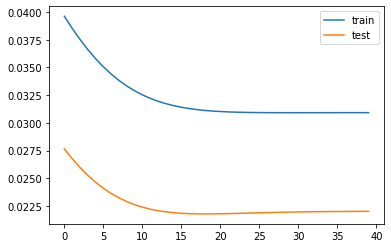

In [14]:
#Generamos plot con los resultados
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [15]:
yhat = model.predict(test_X)

In [16]:
#Crear columna correlaciones
df = pd.DataFrame({'yhat':yhat.reshape(yhat.shape[0],), 'test_y':test_y})
df['corr'] = df['yhat']*df['test_y']

#Si las correlaciones son positivas=acierto, negativas=error
lista =[]
for index, row in df.iterrows():
    if row['corr'] > 0:
        lista.append('Acierto')
    else:
        lista.append('Error')

serie = pd.Series(lista, index = df.index)
df['res'] = serie

#Contamos resultados y buscamos que porcentaje de acierto tenemos
df['res'].value_counts()[0]

a = df['res'].value_counts()[0] / (df['res'].value_counts()[0]+df['res'].value_counts()[1])

print(f'% de acierto: {a*100}%')

% de acierto: 84.27299703264094%


In [17]:
df.head(50)

,yhat,test_y,corr,res
0,0.097946,0.093865,0.009194,Acierto
1,0.097946,0.091014,0.008914,Acierto
2,0.097946,-0.022854,-0.002238,Error
3,0.097946,0.227755,0.022308,Acierto
4,0.097946,0.068242,0.006684,Acierto
5,0.097946,0.068238,0.006684,Acierto
6,0.097946,0.222012,0.021745,Acierto
7,0.097946,0.142248,0.013933,Acierto
8,0.097946,0.011351,0.001112,Acierto
9,0.097946,0.125187,0.012262,Acierto
